# Imports and logistics

In [3]:
conda install numba

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



## Package Plan ##

  environment location: /Users/lucyjiao/Desktop/thesis/.conda

  added / updated specs:
    - numba


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.2.1              |       h0d3ecfb_1         2.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.7 MB

The following packages will be UPDATED:

  openssl                                  3.2.1-h0d3ecfb_0 --> 3.2.1-h0d3ecfb_1 



                                           

In [4]:
# https://github.com/quantumlib/OpenFermion for open fermion my saviors

# Generate Random Gaussian State

In [1]:
import numpy as np
import numba as nb

import cirq

import openfermion as of
from openfermion.testing.testing_utils import random_quadratic_hamiltonian
from openfermion.ops import QuadraticHamiltonian
import math

In [2]:
# set up the number of orbs and a random quadratic Hamiltonian
norbs =10
qh = random_quadratic_hamiltonian(norbs, conserves_particle_number=True, real=True, expand_spin=False, seed=2)

In [3]:
gspc = of.circuits.prepare_gaussian_state(
    qubits=cirq.LineQubit.range(0,norbs), quadratic_hamiltonian=qh, occupied_orbitals=None
)

In [4]:
def c_k(k):
    # if k > 2 * len(qubits):
    #     raise ValueError("k cannot be more than 2n")

    qubits = cirq.LineQubit.range(k)

    Zs = [cirq.Z(q) for q in qubits]
    Xs = [cirq.X(q) for q in qubits]
    Ys = [cirq.Y(q) for q in qubits]

    j = math.ceil(k/2)

    j_gate = Xs[j-1] if k % 2 == 1 else Ys[j-1]

    return cirq.PauliString([Zs[i] for i in range(j-1)] + [j_gate])


In [5]:
qs = cirq.LineQubit.range(0,norbs)
c = c_k(k=2)
c2 = c_k(k=3)

In [6]:
print(gspc)

<generator object prepare_gaussian_state at 0x282d38240>


In [7]:
circuit = cirq.Circuit()
# circuit.append(gspc)
circuit.append([cirq.I(q) for q in qs])
# circuit.append([c2*c])

In [8]:
circuit

0: ───I───

1: ───I───

2: ───I───

3: ───I───

4: ───I───

5: ───I───

6: ───I───

7: ───I───

8: ───I───

9: ───I───

In [9]:
simulator = cirq.Simulator()
result = simulator.simulate(circuit)

In [10]:
result

measurements: (no measurements)

qubits: (cirq.LineQubit(0),)
output vector: |0⟩

qubits: (cirq.LineQubit(1),)
output vector: |0⟩

qubits: (cirq.LineQubit(2),)
output vector: |0⟩

qubits: (cirq.LineQubit(3),)
output vector: |0⟩

qubits: (cirq.LineQubit(4),)
output vector: |0⟩

qubits: (cirq.LineQubit(5),)
output vector: |0⟩

qubits: (cirq.LineQubit(6),)
output vector: |0⟩

qubits: (cirq.LineQubit(7),)
output vector: |0⟩

qubits: (cirq.LineQubit(8),)
output vector: |0⟩

qubits: (cirq.LineQubit(9),)
output vector: |0⟩

phase:
output vector: |⟩

In [11]:
result.final_state_vector

array([1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
      dtype=complex64)

In [12]:
dm = cirq.density_matrix_from_state_vector(result.final_state_vector)

In [13]:
# def covariance_jk(density_mat, j, k):
#     if j == k:
#         return 0
    
#     qubits = cirq.LineQubit.range(int(np.log2(density_mat.shape[0]))) 

#     cj = c_k(qubits, j)
#     ck = c_k(qubits, k)

#     circuit = cirq.Circuit()
#     circuit.append([cirq.I(q) for q in qubits])
#     circuit.append([cj*ck])

#     dcsim = cirq.DensityMatrixSimulator()

#     res = dcsim.simulate(circuit, initial_state=density_mat)
#     m = res.final_density_matrix
#     trace = np.trace(m)

#     return 1j * trace

def covariance_jk(state_vector, j, k):
    if j == k:
        return 0
    
    qubits = cirq.LineQubit.range(int(np.log2(len(state_vector)))) 

    cj = c_k(j)
    ck = c_k(k)

    circuit = cirq.Circuit()
    circuit.append([cirq.I(q) for q in qubits])
    circuit.append([cj*ck])

    # # print(cj, ck)

    # dcsim = cirq.Simulator()

    # res = dcsim.simulate(circuit, initial_state=state_vector)
    # m = cirq.density_matrix_from_state_vector(res.final_state_vector)
    # trace = np.trace(m)

    # print((cj*ck).matrix(), (cj*ck), cj, ck)

    # print(circuit.unitary(), j, k, cj*ck)

    expectation = state_vector.conj() @ (circuit.unitary() @ state_vector)

    # print("expectation:", expectation)

    return 1j * expectation

def covariance_jk_circ(state_vector, j, k):
    if j == k:
        return 0
    
    qubits = cirq.LineQubit.range(int(np.log2(len(state_vector)))) 

    cj = c_k(j)
    ck = c_k(k)

    circuit = cirq.Circuit()
    circuit.append([cirq.I(q) for q in qubits])
    circuit.append([cj*ck])
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit, initial_state=state_vector)

    expectation = state_vector.conj() @ (result.final_state_vector)

    return 1j * expectation

In [14]:
import timeit, functools
from memory_profiler import memory_usage

# print(timeit.timeit(functools.partial(covariance_jk_circ, result.final_state_vector, 3, 4), number=100))
mem_usage_cric = memory_usage(functools.partial(covariance_jk_circ, result.final_state_vector, 1, 18))
print(max(mem_usage_cric))

# print(timeit.timeit(functools.partial(covariance_jk, result.final_state_vector, 3, 4), number=100))
mem_usage = memory_usage(functools.partial(covariance_jk, result.final_state_vector, 1, 18))
print(max(mem_usage))



122.109375
158.6875


In [15]:
covariance_jk(result.final_state_vector, 3, 4)


(-1+0j)

In [16]:
covariance_jk_circ(result.final_state_vector, 3, 4)

(-1+0j)

In [17]:
# def covariance(density_mat):
#     n = int(np.log2(density_mat.shape[0]))

#     covariance_mat = np.array([[covariance_jk(density_mat=density_mat, j=j, k=k)for j in range(1,2*n + 1)] for k in range(1,2*n + 1)])
#     return covariance_mat

def covariance_circ(state_vec):
    n = int(np.log2(len(state_vec)))

    covariance_mat = np.array([[covariance_jk_circ(state_vec, j=j, k=k) for j in range(1,2*n + 1)] for k in range(1,2*n + 1)])
    return covariance_mat
    
def covariance(state_vec):
    n = int(np.log2(len(state_vec)))

    covariance_mat = np.array([[covariance_jk(state_vec, j=j, k=k) for j in range(1,2*n + 1)] for k in range(1,2*n + 1)])
    return covariance_mat
    
    

In [18]:
import timeit, functools
from memory_profiler import memory_usage

print(timeit.timeit(functools.partial(covariance_circ, result.final_state_vector), number=10))
mem_usage_cric = memory_usage(functools.partial(covariance_circ, result.final_state_vector))
print(max(mem_usage_cric))

print(timeit.timeit(functools.partial(covariance, result.final_state_vector), number=10))
mem_usage = memory_usage(functools.partial(covariance, result.final_state_vector))
print(max(mem_usage))

2.702063959033694
83.1875
55.44587012496777
166.484375


In [19]:
covariance(result.final_state_vector) == covariance_circ(result.final_state_vector)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ T

In [20]:
cirq.density_matrix_from_state_vector(result.final_state_vector)

array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

In [21]:
covariance(result.final_state_vector)

array([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.

In [22]:
print(c_k(1),
c_k(2),
c_k(3), 
c_k(4)
)

X(q(0)) Y(q(0)) Z(q(0))*X(q(1)) Z(q(0))*Y(q(1))


In [23]:
def schatten_norm(A, p):
    # Compute the singular values
    singular_values = np.linalg.svd(A, compute_uv=False)
    
    # Raise the singular values to the power of p, sum them, and take the p-th root
    if p == np.inf:
        # The Schatten infinity norm is just the maximum singular value
        return np.max(singular_values)
    else:
        # Compute the sum of the singular values raised to the power p and then take the p-th root
        return np.sum(singular_values**p)**(1/p)

In [24]:
def schatten_norm_pow(A, p):
    '''
    Computes the modified Schatten norm to the p power

    @param: A: matrix to take the norm of
    @param: p: the order for the Schatten norm
    '''
    # Compute the singular values
    singular_values = np.linalg.svd(A, compute_uv=False)
    
    # Raise the singular values to the power of p, sum them, and take the p-th root
    if p == np.inf:
        # The Schatten infinity norm is just the maximum singular value
        return np.max(singular_values)
    else:
        # Compute the sum of the singular values raised to the power p
        return np.sum(singular_values**p)

In [25]:

def nongaussianity(state_vec, alpha):
    '''
    @param: density_matrix: desity matrix of the state to examine
    @param: alpha: the order for the schatten norm
    '''
    cm = covariance(state_vec)
    norm_power = schatten_norm_pow(cm, alpha)

    n = int(np.log2(state_vec.shape[0]))
    return n - norm_power/2


# def nongaussianity(density_matrix, alpha):
#     '''
#     @param: density_matrix: desity matrix of the state to examine
#     @param: alpha: the order for the schatten norm
#     '''
#     cm = covariance(density_matrix)
#     norm_power = np.linalg.norm(cm)**2

#     n = int(np.log2(density_matrix.shape[0]))
#     return n - norm_power/2



In [26]:
sv = result.final_state_vector

In [27]:
nongaussianity(sv, 2)

0.0

In [28]:
m = covariance(sv)
norm_power = schatten_norm_pow(m, 2)
norm = schatten_norm(m, 2)

print(norm_power, norm)

n = int(np.log2(dm.shape[0]))
print(n)

print(norm_power/2, norm/2)



20.0 4.47213595499958
10
10.0 2.23606797749979


In [29]:
n - norm_power/2

0.0

In [30]:
np.trace((m.conj() @ m).real) 

-20.0

# simulate nongaussianity of random gaussian state (should be 0)

In [31]:
# set up the number of orbs and a random quadratic Hamiltonian
norbs = 6
qh = random_quadratic_hamiltonian(norbs, conserves_particle_number=True, real=True, expand_spin=False)
gspc = of.circuits.prepare_gaussian_state(
    qubits=cirq.LineQubit.range(0,norbs), quadratic_hamiltonian=qh, occupied_orbitals=None
)
circuit = cirq.Circuit()
circuit.append(gspc)
simulator = cirq.Simulator()
result = simulator.simulate(circuit)

In [32]:
nongaussianity(result.final_state_vector, 2)

-9.790742714343992e-07

In [33]:
def covariance_jk_matrix(density_matrix, j, k):
    if j == k:
        return 0
    
    qubits = cirq.LineQubit.range(int(np.log2(len(density_matrix)))) 

    cj = c_k(j)
    ck = c_k(k)

    circuit = cirq.Circuit()
    circuit.append([cirq.I(q) for q in qubits])
    circuit.append([cj*ck])

    expectation = np.trace((density_matrix @ circuit.unitary()))

    return 1j * expectation

def covariance_matrix(denisty_matrix):
    n = int(np.log2(len(denisty_matrix)))

    covariance_mat = np.array([[covariance_jk_matrix(denisty_matrix, j=j, k=k) for j in range(1,2*n + 1)] for k in range(1,2*n + 1)])
    return covariance_mat

def nongaussianity_matrix(density_matrix, alpha):
    '''
    @param: density_matrix: desity matrix of the state to examine
    @param: alpha: the order for the schatten norm
    '''
    cm = covariance_matrix(density_matrix)
    norm_power = schatten_norm_pow(cm, alpha)

    n = int(np.log2(density_matrix.shape[0]))
    return n - norm_power/2



In [34]:
nongaussianity_matrix(cirq.density_matrix_from_state_vector(result.final_state_vector), 2)

-1.073230119885693e-06

In [35]:

# sum of squares from stackexchange https://stackoverflow.com/questions/56047264/generate-two-random-numbers-whose-square-sum-1
from functools import reduce
from math import sqrt
from random import gauss, uniform
rng = np.random.default_rng()

def sum_of_squares_is_one(n = 2):
    if ((n < 2) or (int(n) != n)) is True:
        raise Exception("Invalid argument for n")
    l = [gauss(0.0, 1.0) for _ in range(n)]
    norm = sqrt(reduce(lambda sum,x: sum + x*x, l, 0.0)) # / uniform(0.95, 1.05)
    return [x / norm for x in l]


def superposition(states):
    '''
        Generates a superposition of the given states
        @param states: a list of quantum states in state vector form
    '''

    n = len(states)
    coeffs = cirq.testing.random_superposition(n)
    states = np.asarray(states)

    modified_state_vector = np.sum([states[i]*coeffs[i] for i in range(n)], axis=0)

    # print(n, coeffs, states)
    # print(sum(np.array(coeffs)**2))
    return modified_state_vector/np.linalg.norm(modified_state_vector)

In [36]:
s = superposition([[1, 0, 0, 0], [1,0, 0, 0], [1, 0, 0, 0]])
s

array([-0.8292901+0.55881833j,  0.       +0.j        ,
        0.       +0.j        ,  0.       +0.j        ])

In [37]:
np.linalg.norm(s)

1.0000000000000002

In [38]:
sum(abs(s**2))

1.0000000000000002

In [39]:
1/sqrt(2)

0.7071067811865475

In [40]:
def generate_random_gaussian_state_vector(norbs):
    qh = random_quadratic_hamiltonian(norbs, conserves_particle_number=True, real=True, expand_spin=False)
    gspc = of.circuits.prepare_gaussian_state(
        qubits=cirq.LineQubit.range(0,norbs), quadratic_hamiltonian=qh, occupied_orbitals=None
    )
    circuit = cirq.Circuit()
    circuit.append(gspc)
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    return result.final_state_vector

In [41]:
# this is slower
# def generate_random_gaussian_state_vector(norbs):
#     qh = random_quadratic_hamiltonian(norbs, conserves_particle_number=True, real=True, expand_spin=False)
#     _g_energy, g_state = of.circuits.jw_get_gaussian_state(qh, occupied_orbitals=None)
#     return g_state

In [42]:
v = generate_random_gaussian_state_vector(2)
v

array([ 0.        +0.000000e+00j, -0.8574582 +5.250417e-17j,
        0.51455367+0.000000e+00j,  0.        +0.000000e+00j],
      dtype=complex64)

In [43]:
sum(v**2)

(0.9999999701976776-9.004026403762217e-17j)

In [44]:
def generate_n_samples(n, norbs):
    # return np.fromfunction(lambda x: random_quadratic_hamiltonian(norbs, conserves_particle_number=True, real=True, expand_spin=False), shape=(n,))
    states = [generate_random_gaussian_state_vector(norbs) for _ in range(n)]

    N = 2**norbs

    s = [np.pad(state, (0, N - len(state))) for state in states]

    return s


In [45]:
def sample_superposition(n, norbs):
    return superposition(generate_n_samples(n, norbs))

In [46]:
n = 2
data = []
for norbs in range(2, 10):
    data.append(np.max([nongaussianity(sample_superposition(n, norbs), 2) for _ in range(100)]))

data

[0.9999696540202292,
 2.5734185077079004,
 2.711385304015254,
 3.2614503912649493,
 3.7072898293721344,
 4.951925112518079,
 5.623157594368417,
 5.5615067889252146]

In [47]:
nongaussianity(sample_superposition(2, 8), 2)

2.6850866422824007

In [48]:
np.log(range(2,6))

array([0.69314718, 1.09861229, 1.38629436, 1.60943791])

In [49]:
logdata = data/np.log(range(2, 8))
logdata

ValueError: operands could not be broadcast together with shapes (8,) (6,) 

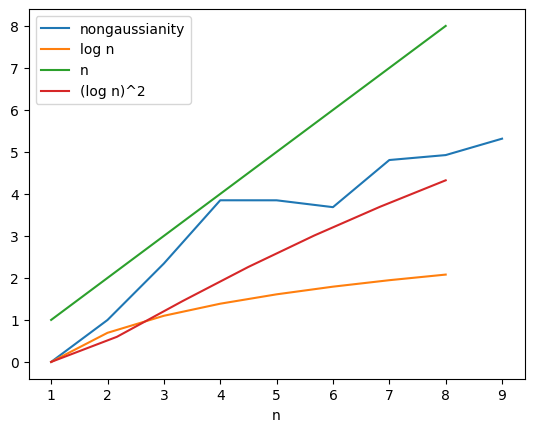

In [172]:
import matplotlib.pyplot as plt
# plt.plot([1,2,3,4,5,6,7], np.concatenate(([0], logdata)), label="nongaussianity/log n")
plt.plot(range(1, len(data) + 2), np.concatenate([[0] , data]), label="nongaussianity")

plt.plot(range(1, len(data) + 1), np.log(range(1, len(data)+1)), label="log n")
# plt.plot([1,2,3,4,5,6,7, 8, 9], np.sqrt(range(1, 10)))
plt.plot(np.linspace(1,8, 7), np.linspace(1,8, 7), label="n")
# plt.plot(np.linspace(1,8, 7), np.linspace(1,8, 7)/np.log(np.linspace(1,8, 7)), label="n/ log n")
plt.plot(np.linspace(1,8, 7), np.log(np.linspace(1,8, 7))**2, label="(log n)^2")

plt.xlabel("n")
plt.legend()

In [44]:
m = 0
n = 2
norbs = 1
for _ in range(10):
    ss = sample_superposition(n, norbs)
    print("super",ss)
    ng = nongaussianity(ss, 2)
    print("ng:", ng)
    m = max(m, ng)

super [ 0.15771054+0.02237701j -0.01914288-0.9870462j ]
ng: 0.09891815480286759
super [-0.54412742+0.83900259j  0.        +0.j        ]
ng: -4.440892098500626e-16
super [0.7571544-0.65323595j 0.       +0.j        ]
ng: 2.220446049250313e-16
super [0.568423  +0.42057997j 0.08251711-0.70228107j]
ng: 0.9999999997577596
super [-0.3945595 -0.10588357j  0.15080378+0.90020536j]
ng: 0.556146988705311
super [ 0.        +0.j         -0.88316689-0.46905888j]
ng: -4.440892098500626e-16
super [0.04856275+0.99882013j 0.        +0.j        ]
ng: 4.440892098500626e-16
super [-0.66442183-0.11478109j  0.37058495+0.63877674j]
ng: 0.9917666418078315
super [-0.64934102+0.76049737j  0.        +0.j        ]
ng: 0.0
super [-0.10324861+0.27600088j -0.93619658+0.19157035j]
ng: 0.3171845524480984


In [45]:
m

0.9999999997577596

In [46]:
import pickle as pkl

In [47]:
np.save( "./metric_data.npy", [0, 1.9582815805976208, 2.966501383823812, 3.665779162216511, 4.218889294320181, 5.494926469102586, 6.433891328126746, 6.929726791646733, 7.9513785851856404])

In [1139]:
np.save("./metric_data_2.npy",  [0] + data)

In [1318]:
np.max([nongaussianity(sample_superposition(2, 8), 2) for _ in range(2)])

1.9836284635864363

## Optimizing using numpy hopefully

In [90]:
%load_ext autoreload
%autoreload 2

from multiprocessing import Pool
from metric_sim import single_nongaussianity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import timeit, functools

def generate_random_gaussian_state_vector_circ(norbs):
    qh = random_quadratic_hamiltonian(norbs, conserves_particle_number=True, real=True, expand_spin=False)
    gspc = of.circuits.prepare_gaussian_state(
        qubits=cirq.LineQubit.range(0,norbs), quadratic_hamiltonian=qh, occupied_orbitals=None
    )
    circuit = cirq.Circuit()
    circuit.append(gspc)
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    return result.final_state_vector

def generate_random_gaussian_state_vector(norbs):
    qh = random_quadratic_hamiltonian(norbs, conserves_particle_number=True, real=True, expand_spin=False)
    _g_energy, g_state = of.circuits.jw_get_gaussian_state(qh, occupied_orbitals=None)
    return g_state

print(timeit.timeit(functools.partial(generate_random_gaussian_state_vector_circ, 8), number=1000))
print(timeit.timeit(functools.partial(generate_random_gaussian_state_vector, 8), number=1000))



2.8591102499049157
5.549903000006452


In [70]:
# def generate_n_samples(n, norbs):
#     # return np.fromfunction(lambda x: random_quadratic_hamiltonian(norbs, conserves_particle_number=True, real=True, expand_spin=False), shape=(n,))
#     pool = Pool()
#     states = pool.map(generate_random_gaussian_state_vector, np.full(n, norbs))
#     return states

def generate_n_samples(n, norbs):
    # return np.fromfunction(lambda x: random_quadratic_hamiltonian(norbs, conserves_particle_number=True, real=True, expand_spin=False), shape=(n,))
    states = [generate_random_gaussian_state_vector(norbs) for _ in range(n)]
    return states

def sample_superposition(n, norbs):
    return superposition(generate_n_samples(n, norbs))

# def single_nongaussianity(n, norbs, alpha):
#     return nongaussianity(superposition(generate_n_samples(n, norbs)), alpha)

# def single_nongaussianity(n, norbs):
#     def ng(alpha):
#         return nongaussianity(superposition(generate_n_samples(n, norbs)), alpha)
#     return ng

In [101]:
single_nongaussianity(2,8, 2)

2.075192248287645

In [102]:
n = 2
reps = 100
data = []
pool = Pool(4)

args = [(n, 14, 2) for _ in range(reps)]


In [103]:
np.max(pool.starmap(single_nongaussianity, args))

KeyboardInterrupt: 

In [98]:
n = 2
reps = 100
data = []
pool = Pool(4)
for norbs in range(7, 8):
    # value = np.empty((), dtype=object)
    # value[()] = (n, norbs, 2)
    # args = np.full(n, value, dtype=object)
    args = [(n, norbs, 2) for _ in range(reps)]
    data.append(np.max(pool.starmap(single_nongaussianity, args)))

KeyboardInterrupt: 

In [79]:
data

[-8.881784197001252e-16,
 0.571605041111046,
 1.7825503682897517,
 1.449693634657021,
 0.9458706671821977,
 3.292857457876906]

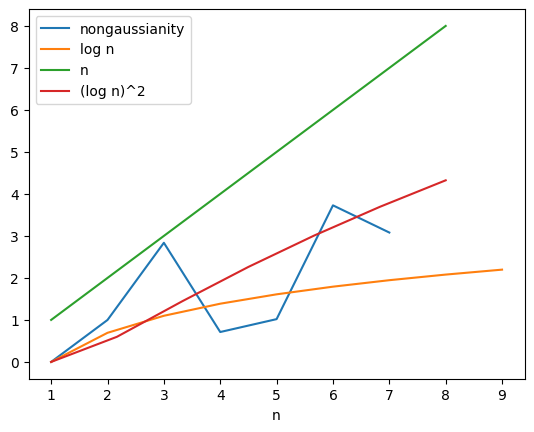

In [74]:
import matplotlib.pyplot as plt
# plt.plot([1,2,3,4,5,6,7], np.concatenate(([0], logdata)), label="nongaussianity/log n")
plt.plot([1,2,3,4,5,6,7], [0] + data, label="nongaussianity")

plt.plot([1,2,3,4,5,6,7, 8, 9], np.log(range(1, 10)), label="log n")
# plt.plot([1,2,3,4,5,6,7, 8, 9], np.sqrt(range(1, 10)))
plt.plot(np.linspace(1,8, 7), np.linspace(1,8, 7), label="n")
# plt.plot(np.linspace(1,8, 7), np.linspace(1,8, 7)/np.log(np.linspace(1,8, 7)), label="n/ log n")
plt.plot(np.linspace(1,8, 7), np.log(np.linspace(1,8, 7))**2, label="(log n)^2")

plt.xlabel("n")
plt.legend()

# Testing on Haar random states

In [52]:
qubits = cirq.LineQubit.range(2) 
circuit = cirq.Circuit()
circuit.append([cirq.I(q) for q in qubits])
simulator = cirq.Simulator()
result = simulator.simulate(circuit)

In [53]:
def get_zero_state(n):
    qubits = cirq.LineQubit.range(n) 
    circuit = cirq.Circuit()
    circuit.append([cirq.I(q) for q in qubits])
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    return result.final_state_vector

def get_b_nonguass_samples(b, n):
    zero  = get_zero_state(n)
    return np.array([of.testing.random_unitary_matrix(len(zero)) @ zero for _ in range(b)])


In [186]:
np.linspace(11, 20, 10)

array([11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])

In [187]:
nongaussianity(of.testing.random_unitary_matrix(len(result.final_state_vector)) @ result.final_state_vector, 2)

0.9253940284685866

In [188]:
ng_np = np.vectorize(get_b_nonguass_samples)

In [189]:
def nongaussianity2(state_vec):
    return nongaussianity(state_vec, 2)

In [190]:
np.apply_along_axis(nongaussianity2, 1, ng_np(10, 2))

array([0.84111812, 0.81820521, 0.95000737, 0.96934759, 0.468391  ,
       0.95109953, 0.9040438 , 0.93828515, 0.61679923, 0.96084007])

In [191]:
b = 10
data_haar = []
for n_haar in range(1, 10):
    data_haar.append(np.max(np.apply_along_axis(nongaussianity2, 1, ng_np(b, n_haar))))

data_haar

[0.997920056482833,
 0.9971037970919325,
 1.736078283536238,
 2.9896338613064097,
 4.079480095620881,
 5.244239463609856,
 6.416809309994166,
 7.69128787276909,
 8.755453032122249]

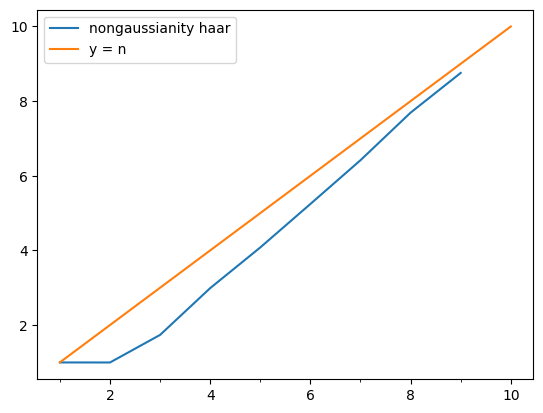

In [208]:
import matplotlib.pyplot as plt
fig = plt.plot([1,2,3,4,5,6,7, 8, 9], data_haar, label="nongaussianity haar")
# plt.plot([1,2,3,4,5,6,7, 8, 9], np.log(range(1, 10)))
# plt.plot([1,2,3,4,5,6,7, 8, 9], np.sqrt(range(1, 10)))
plt.plot(np.linspace(1,10, 9), np.linspace(1,10, 9), label="y = n")
fig[0].axes.xaxis.set_major_locator(plt.MultipleLocator(2))
fig[0].axes.xaxis.set_minor_locator(plt.MultipleLocator(1))

plt.legend()

In [201]:
fig[0].axes.xaxis.set_ma

<Axes: >

# Lambda Metric
$\|\Lambda (\rho \otimes \rho)\|$ as a metric

In [81]:
def lambda_op(state_vector):
    n = int(np.log2(len(state_vector)))
    vecs = []
    qubits = cirq.LineQubit.range(n) 

    for j in range(1,2* n + 1):
        c_j = c_k(j)
        
        circuit = cirq.Circuit()
        circuit.append([cirq.I(q) for q in qubits])
        circuit.append([c_j])
        print(circuit)
        simulator = cirq.Simulator()
        result = simulator.simulate(circuit, initial_state=state_vector)
        vecs.append(result.final_state_vector)

    return np.sum(vecs, axis=0)

In [85]:
test = 3

# get_zero_state(test).conj() @ lambda_op(lambda_op(get_zero_state(test)))
(lambda_op(get_zero_state(test)))
get_zero_state(test)

0: ───I───PauliString(+X)───

1: ───I─────────────────────

2: ───I─────────────────────
0: ───I───PauliString(+Y)───

1: ───I─────────────────────

2: ───I─────────────────────
0: ───I───PauliString(+Z)───
          │
1: ───I───X─────────────────

2: ───I─────────────────────
0: ───I───PauliString(+Z)───
          │
1: ───I───Y─────────────────

2: ───I─────────────────────
0: ───I───PauliString(+Z)───
          │
1: ───I───Z─────────────────
          │
2: ───I───X─────────────────
0: ───I───PauliString(+Z)───
          │
1: ───I───Z─────────────────
          │
2: ───I───Y─────────────────


array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
      dtype=complex64)

In [ ]:
def lam2(state_vector):
    